In [6]:
import json

import bz2
import re
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

Сегодня мы будем заниматься классифицированием текстов.

Будем различать положительные и отрицательные отзывы на банки.

Для начала давайте заберем все тексты из [этой](http://math-info.hse.ru/f/2016-17/nes-ml/banki_responses.json.bz2) ссылки

In [7]:
responses = []
with bz2.BZ2File('./data/banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked']:
            responses.append(resp)

201030it [03:04, 1092.11it/s]


In [41]:
responses[1]

{'author': 'agelun',
 'bank_license': 'лицензия № 1481',
 'bank_name': 'Сбербанк России',
 'city': 'г. Москва',
 'datetime': '2015-06-05 15:00:54',
 'num_comments': 2,
 'rating_grade': 1,
 'rating_not_checked': False,
 'text': 'Открыт вклад и счет в USD. Плюс к этому есть зарплатная карта, в рублях, само собой. Сегодня пришел в указанное отделение с целью пополнить долларовый счёт на 700 USD.\xa0Дал операционисту паспорт, зарплатную карту (т.к. на окошке написано "приготовьте карту для подтверждения операции" или что-то подобное и в прошлый раз у меня ее потребовали) и сказал, что нужно положить деньги на ДОЛЛАРОВЫЙ счет.\xa0Операционист всё взяла, что-то делала-крутила-вертела, вставила карту в терминал, сказала "введите пин", я ввёл пин, получил в ответ чек, где было написано, что доллары были внесены.... на счёт КАРТЫ! в РУБЛЯХ! Вопрос банку №1, риторический:  Я не понимаю, кем нужно быть, чтобы сознательно проводить такие операции??? за углом, меньше чем через квартал, курс приёма 

In [42]:
import pymorphy2

In [43]:
morph = pymorphy2.MorphAnalyzer()

In [54]:
norm_text = []
for word in responses[2]['text'].split(' '):
    norm_text.append(morph.normal_forms(word)[0])

In [55]:
' '.join(norm_text)

'добрый времени! вчера я поступить смс-уведомление, о том, что банк делать я эксклюзивный предложение по кредиту. являться клиент банка в настоящее время, но в связь с проявить инициатива банка, решить воспользоваться предложением. приехать сегодня днём в отделение, заполнить анкету, сразу пояснить - "без страховки", сотрудник (имя не помню) начало сразу приводить я довод о отказ в кредитование без страховка (ну мы то понимать что это они зарплата), я молча она выслушал, в конец ещё раз пояснить - "без страховки", поставить соответствующий пункт в заявление на кредит. сотрудник принять заявление и сказала: "мы вы позвонить и уведомить о решение банка", я уехал... вечером (18:00) сотрудник я действительно перезвонила, сообщить что заявка одобрена, я сказал, что постараться успеть... успеть - приехать 19:45, подхожу, сотрудник говорит: "присаживайтесь", я присел, быть чувство скрытый тревоги, и не зря, я ещё раз уточнить "без страховки", и тут сотрудник я уведомляет: "во одобрить кредит 

Заметим что текст "грязный", то есть в нем есть разные ненужные символы, бесполезные цифры.

Еще видно что не у всех текстов есть оценки. Нам, чтобы научить классификатор нужны только те, где оценки уже проставлены

Здесь нам пригодятся регулярные выражения. Они на основе каких-то правил обрабатывают текст. Например здесь мы хотим оставить только слова, так чтобы между словами были пробелы

In [39]:
regex = r'\b\w+\b'

' '.join(re.findall(regex, responses[2]['text'].lower()))

'доброго времени вчера мне поступило смс уведомление о том что банк делает мне эксклюзивное предложение по кредиту являюсь клиентом банка в настоящее время но в связи с проявленной инициативой банка решил воспользоваться предложением приехал сегодня днем в отделение заполнил анкету сразу пояснил без страховки сотрудник имени не помню начала сразу приводить мне доводы об отказе в кредитовании без страховки ну мы то понимаем что это их зарплата я молча ее выслушал в конце еще раз пояснил без страховки поставил соответствующий пункт в заявлении на кредит сотрудник принял заявление и сказала мы вам позвоним и уведомим о решении банка я уехал вечером 18 00 сотрудник мне действительно перезвонила сообщила что заявка одобрена я сказал что постараюсь успеть успел приехал 19 45 подхожу сотрудник говорит присаживайтесь я присел было чувство скрытой тревоги и не зря я еще раз уточнил без страховки и тут сотрудник меня уведомляет вам одобрен кредит с минимальным пакетом страхования я ей еще раз по

Сформируем выборку для обучения отобрав только размеченные и почищенные отзывы

In [15]:
responses = [i for i in responses if i['rating_grade'] is not None]
texts = [' '.join(re.findall(regex, i['text'].lower())) for i in responses]
ratings = [i['rating_grade'] for i in responses]

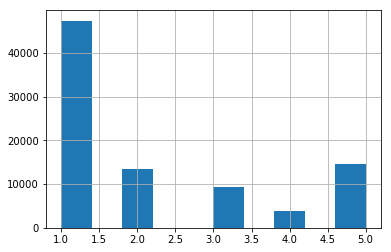

In [16]:
plt.hist(ratings)
plt.grid()

# Часть 1

Мы уже немного пробовали позаниматься анализов текстов, поэтому я пропущу введение и сразу перейду к tf-idf

#### TF-IDF

Ещё один способ работы с текстовыми данными — TF-IDF (Term Frequency–Inverse Document Frequency). Рассмотрим коллекцию текстов $D$. Для каждого уникального слова $t$ из документа $d \in D$ вычислим следующие величины:

Term Frequency – количество вхождений слова в отношении к общему числу слов в тексте: $$\text{tf}(t, d) = \frac{n_{td}}{\sum_{t \in d} n_{td}},$$ где $n_{td}$ — количество вхождений слова $t$ в текст $d$.
Inverse Document Frequency $$\text{idf}(t, D) = \log \frac{\left| D \right|}{\left| \{d\in D: t \in d\} \right|},$$ где $\left| \{d\in D: t \in d\} \right|$ – количество текстов в коллекции, содержащих слово $t$.

Тогда для каждой пары (слово, текст) $(t, d)$ вычислим величину: $$\text{tf-idf}(t,d, D) = \text{tf}(t, d)\cdot \text{idf}(t, D).$$

Отметим, что значение $\text{tf}(t, d)$ корректируется для часто встречающихся общеупотребимых слов при помощи значения $\text{idf}(t, D).$

Признаковым описанием одного объекта $d \in D$ будет вектор $\bigg(\text{tf-idf}(t,d, D)\bigg)_{t\in V}$, где $V$ – словарь всех слов, встречающихся в коллекции $D$.



In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [56]:
vectorizer = TfidfVectorizer(encoding='utf8', min_df=0.05, max_df=0.95)
vectorizer.fit(texts)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf8', input='content',
        lowercase=True, max_df=0.95, max_features=None, min_df=0.05,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

Теперь наш vectorizer обучился на нашей выборке и может генерировать вектор для каждого предложения

In [20]:
X = vectorizer.transform(texts)
Y = (np.array(ratings) > 3).astype(int)

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, Y)

In [23]:
classifier = LogisticRegression()

In [24]:
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [25]:
predictions = classifier.predict_proba(X_test)

In [28]:
fpr, tpr, _ = roc_curve(y_test, predictions[:, 1])

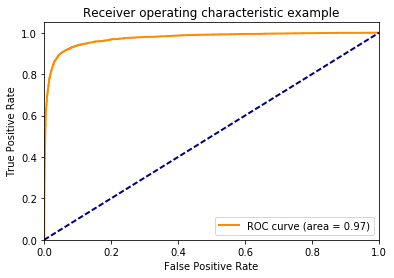

In [31]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, predictions[:, 1]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Задача

Теперь мы посчитали roc-auc score. Он очень неплохой. Теперь сами попробуйте посчитать accuracy

In [32]:
## ToDo посчитать accuracy

### Логистическая регрессия

Это очень неплохой вид линейных моделей. Главная причина ее использования - она умеет находить важность конкретной фичи для общего качества

In [35]:
f_weights = zip(vectorizer.get_feature_names(), classifier.coef_[0])
f_weights = sorted(f_weights, key=lambda i: i[1])
for i in range(1,10):
    print('%s, %.2f' % f_weights[-i])
    
print('...')
for i in reversed(range(1,10)):
    print('%s, %.2f' % f_weights[i])

спасибо, 13.97
приятно, 10.83
благодарность, 9.17
быстро, 8.30
доволен, 6.92
поблагодарить, 6.55
очень, 6.14
оперативно, 5.63
молодцы, 5.43
...
никто, -3.37
сказали, -3.38
ответа, -3.56
невозможно, -3.63
нет, -3.76
вы, -3.88
почему, -4.19
зачем, -4.22
ответ, -4.59


# Часть 2

TF-IDF крутая штука, но она не учитывает много всего что помогло бы нам лучше понимать тексты. Например, самое важное, она не достает зависимости между словами. Это очень важно, ведь что может лучше описывать слово чем слова рядом?

К счастью лет 5 назад гуглом была придумана волшебная штука под названием word2vec

Word2vec собирает статистику по совместному появлению слов в фразах, после чего методами нейронных сетей решает задачу снижения размерности и выдает на выходе компактные векторные представления слов, в максимальной степени отражающие отношения этих слов в обрабатываемых текстах

Работая со словами в векторном представлении, мы работаем в 100-300 мерном пространстве. При таких больших размерностях обычное расстояние которое вы учили в школах бесполезно. Обычно для нахождения расстояния между точками используют косинусное расстояние

$$ cosine(A, B) = \frac{\sum_{i=1}^n A_i B_i}{\sqrt{\sum_{i=1}^n A_i}\sqrt{\sum_{i=1}^n A_i}}$$

Вот пример слов в двумерном пространстве

![вот такая картинка](https://www.adityathakker.com/wp-content/uploads/2017/06/word-embeddings-994x675.png)

С помощью такой модели можно делать что угодно со словами, например находить ближайшие, искать ошибки и проверять написание. Вот [тут](https://habr.com/post/249215/) написано подробнее.

Мы можем получить вектор предложения как среднее по векторам всех его слов например.

Давайте сейчас не будем обучать свой word2vec с нуля, а просто возьмем готовый предобученный. 

In [36]:
#to be continued